In [3]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

Data preprocessing

In [4]:
df = pd.read_excel('沪深300.xlsx', header=3)
df = df.dropna(axis = 1, how = 'all')

bool_cols = []
for column in df.columns:
    if df[column].dtype == 'bool':
        bool_cols.append(column)

df.drop(['tech_MA5', 'tech_MA20'], axis=1, inplace=True)

for column in df.columns:
    if df[column].isnull().any() and column not in bool_cols:
        df[column].fillna(df[column].mean(), inplace=True)
df['trend'] = (df['close'] < df['close'].shift(-1))
df = df.iloc[1:,]
df

,Date,open,high,low,close,volume,amt,dealnum,adjfactor,turn,...,stage_high,stage_low,up_days,down_days,breakout_ma,breakdown_ma,history_high_days,history_low_days,bull_bear_ma,trend
1,2012-05-29,2.602,2.661,2.602,2.644,714949008.0,1.875593e+09,11432,1.000000,6.936538,...,True,True,1.0,0.0,False,False,2,1,False,False
2,2012-05-30,2.642,2.647,2.633,2.636,265887198.0,7.017258e+08,5532,1.000000,2.595794,...,True,True,0.0,1.0,False,False,2,1,False,False
3,2012-05-31,2.621,2.645,2.613,2.630,178155984.0,4.681931e+08,4662,1.000000,1.747313,...,True,False,0.0,2.0,False,False,1,0,False,False
4,2012-06-01,2.629,2.660,2.620,2.630,179350035.0,4.734772e+08,5189,1.000000,1.766249,...,False,False,0.0,0.0,False,False,0,0,False,False
5,2012-06-04,2.601,2.604,2.555,2.558,546074272.0,1.413414e+09,7566,1.000000,5.559705,...,False,False,0.0,1.0,False,False,0,0,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3118,2025-03-27,4.011,4.050,3.995,4.027,801525164.0,3.224973e+09,70576,1.207793,0.941116,...,False,False,1.0,0.0,False,False,0,0,False,False
3119,2025-03-28,4.027,4.029,4.000,4.008,704304791.0,2.826193e+09,59846,1.207793,0.828821,...,False,False,0.0,1.0,False,False,0,0,False,False
3120,2025-03-31,4.004,4.024,3.969,3.984,902172863.0,3.600807e+09,110122,1.207793,1.060626,...,False,False,0.0,2.0,False,False,0,0,False,False
3121,2025-04-01,3.988,4.003,3.979,3.982,615015541.0,2.452333e+09,58348,1.207793,0.721766,...,False,False,0.0,3.0,False,False,0,0,False,False


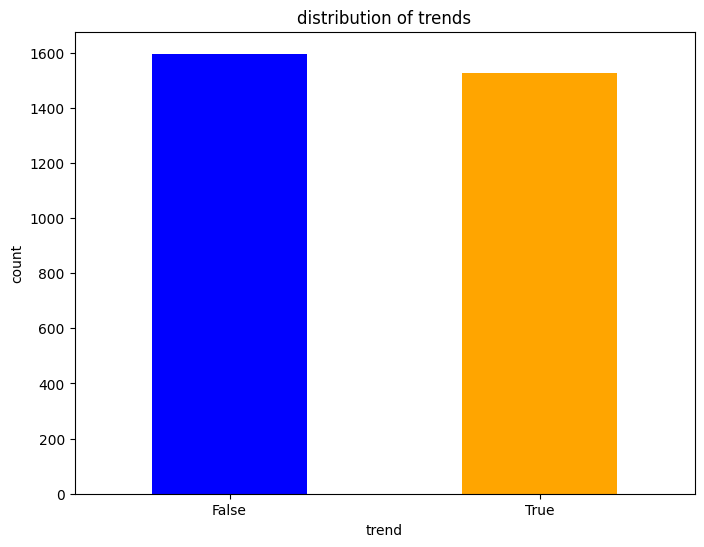

In [5]:
counts = df['trend'].value_counts()

plt.figure(figsize=(8, 6))
counts.plot(kind='bar', color=['blue', 'orange'])
plt.title('distribution of trends')
plt.xlabel('trend')
plt.ylabel('count')
plt.xticks(rotation=0)  
plt.show()


In [6]:
df.columns

Index(['Date', 'open', 'high', 'low', 'close', 'volume', 'amt', 'dealnum',
       'adjfactor', 'turn', 'ADTM', 'ATR', 'BBI', 'BBIBOLL', 'BIAS', 'BOLL',
       'CCI', 'CDP', 'DMA', 'DMI', 'DMI_2', 'DPO', 'ENV', 'EXPMA', 'KDJ',
       'slowKD', 'MA', 'MACD', 'MIKE', 'MTM', 'PRICEOSC', 'PVT', 'RC', 'ROC',
       'RSI', 'SAR', 'SI', 'WR', 'OBV', 'SOBV', 'SRMI', 'PWMI', 'PRDStrong',
       'PRDWeak', 'BOTTOM', 'STD', 'TRIX', 'VHF', 'VMA', 'VMACD', 'VOSC',
       'VSTD', 'WVAD', 'vol_ratio', 'history_high', 'history_high_vol',
       'history_high_amount', 'history_low', 'stage_high', 'stage_low',
       'up_days', 'down_days', 'breakout_ma', 'breakdown_ma',
       'history_high_days', 'history_low_days', 'bull_bear_ma', 'trend'],
      dtype='object')

Parameters

In [7]:
torch.manual_seed(42)
np.random.seed(42)

# Parameters
WINDOW_SIZE = 20
BATCH_SIZE = 64
TARGET_COLUMN = 'trend'
FEATURES = [col for col in df.columns if col not in ['Date', 'trend']]
#FEATURES = ['open', 'high', 'low', 'close', 'volume', 'MACD', 'RSI', 'up_days', 'down_days', 'history_high_days', 'history_low_days', 'trend']
BOOL_FEATURES = [col for col in FEATURES if df[col].dtype == 'bool']
NUM_FEATURES = [col for col in FEATURES if col not in BOOL_FEATURES]
TEST_SIZE = 0.2
EPOCHS = 100
PATIENCE = 5
DEVICE = "cuda"

Dealing with time series dataset

In [8]:
# Dataset class
class TransformerDataset(Dataset):
    def __init__(self, dataframe, window_size, target_col, features):
        self.df = dataframe.copy()
        self.window_size = window_size
        self.target_col = target_col
        self.features = features

        # Convert boolean features to int
        self.df[BOOL_FEATURES] = self.df[BOOL_FEATURES].astype(int)

    def __len__(self):
        return len(self.df) - self.window_size

    def __getitem__(self, idx):
        X = self.df.iloc[idx:idx + self.window_size][self.features].values
        y = self.df.iloc[idx + self.window_size][self.target_col]
        return torch.FloatTensor(X), torch.FloatTensor([y])

Models

In [9]:
# Positional Encoding
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.encoding = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        self.encoding[:, 0::2] = torch.sin(position * div_term)
        self.encoding[:, 1::2] = torch.cos(position * div_term)
        self.encoding = self.encoding.unsqueeze(0)

    def forward(self, x):
        seq_len = x.size(1)
        return x + self.encoding[:, :seq_len, :].to(x.device)


# Transformer model
class TransformerModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, dropout):
        super(TransformerModel, self).__init__()
        self.input_layer = nn.Linear(input_dim, hidden_dim)
        self.positional_encoding = PositionalEncoding(hidden_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim, nhead=4, dim_feedforward=hidden_dim * 4, dropout=dropout, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.output_layer = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.input_layer(x)
        x = self.positional_encoding(x)
        x = self.transformer(x)
        x = self.output_layer(x[:, -1, :])
        return x

Model training

In [10]:
def train_transformer(model, train_loader, val_loader, optimizer, criterion, n_epochs, patience):
    best_model = None
    best_val_loss = float("inf")
    train_losses = []
    val_losses = []
    patience_counter = 0

    for epoch in range(n_epochs):
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        print(f"Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    model.load_state_dict(best_model)
    return model, train_losses, val_losses, best_val_loss

Model evaluation

In [11]:
# Evaluation
def evaluate_transformer_model(model, test_loader):
    model.eval()
    y_true, y_pred, y_prob_pred = [], [], []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)
            outputs = model(X_batch)
            preds = torch.sigmoid(outputs).cpu().numpy()
            y_prob_pred.extend(preds)
            y_pred.extend((preds >= 0.5).astype(int))
            y_true.extend(y_batch.cpu().numpy())
    return np.array(y_true), np.array(y_pred), np.array(y_prob_pred)

# Metrics calculation
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
    }

Visualization

In [12]:
# Visualization
def plot_loss(train_losses, val_losses, model_name):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.title(f"{model_name} Loss Curve")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

Main

In [13]:
# Main function
def main_transformer():
    # Split data into train and test sets
    train_size = int(len(df) * (1 - TEST_SIZE))
    train_data = df.iloc[:train_size]
    test_data = df.iloc[train_size:]

    # TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=6)

    # the best model and its validation loss
    best_model_state = None
    best_val_loss = float('inf')
    final_train_losses = None
    final_val_losses = None
    best_fold_scaler = None

    for fold, (train_idx, val_idx) in enumerate(tscv.split(train_data)):
        print(f"Fold {fold + 1}")
        fold_train_data = train_data.iloc[train_idx]
        fold_val_data = train_data.iloc[val_idx]

        # Scale data
        scaler = StandardScaler()
        scaler.fit(fold_train_data[NUM_FEATURES])
        fold_train_data[NUM_FEATURES] = scaler.transform(fold_train_data[NUM_FEATURES])
        fold_val_data[NUM_FEATURES] = scaler.transform(fold_val_data[NUM_FEATURES])

        # Create datasets and loaders
        train_dataset = TransformerDataset(fold_train_data, WINDOW_SIZE, TARGET_COLUMN, FEATURES)
        val_dataset = TransformerDataset(fold_val_data, WINDOW_SIZE, TARGET_COLUMN, FEATURES)
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

        # Model
        hidden_dim = 32
        num_layers = 2
        drop_out = 0
        lr = 0.0001
        weight_decay = 0
        
        transformer_model = TransformerModel(len(FEATURES), hidden_dim, num_layers, 1, drop_out).to(DEVICE)
        optimizer = torch.optim.Adam(transformer_model.parameters(), lr=lr, weight_decay=weight_decay)
        criterion = nn.BCEWithLogitsLoss()
        transformer_model, train_losses, val_losses,fold_best_val_loss = train_transformer(transformer_model, train_loader, val_loader, optimizer, criterion, EPOCHS, PATIENCE)
        print(f"Fold {fold+1} The best validation loss is: {fold_best_val_loss:.4f}")

        # save the best model
        if fold_best_val_loss < best_val_loss:
            best_val_loss = fold_best_val_loss
            best_model_state = transformer_model.state_dict().copy()
            final_train_losses = train_losses
            final_val_losses = val_losses
            best_fold_scaler = scaler
            print(f"The best model is saved in Fold {fold+1}")

    final_model = TransformerModel(len(FEATURES), hidden_dim, num_layers, 1, drop_out).to(DEVICE)
    final_model.load_state_dict(best_model_state)

    # plot the loss curves
    plot_loss(final_train_losses, final_val_losses, "Transformer")

    # evaluation in the test set
    print("\nevaluating the model on the test set...")
    test_data[NUM_FEATURES] = best_fold_scaler.transform(test_data[NUM_FEATURES])
    test_dataset = TransformerDataset(test_data, WINDOW_SIZE, TARGET_COLUMN, FEATURES)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    transformer_actuals, transformer_preds, transformer_prob_preds = evaluate_transformer_model(final_model, test_loader)
    np.save("transformer_prob_preds.npy", transformer_prob_preds)

    # calculate the metrics for the transformer
    transformer_metrics = calculate_metrics(transformer_actuals, transformer_preds)

    print("\nTransformer's performance:")
    for metric, value in transformer_metrics.items():
        print(f"{metric}: {value:.6f}")

    return {
        'model': final_model,
        'transformer_metrics': transformer_metrics,
        'transformer_preds': transformer_preds,
        'transformer_actuals': transformer_actuals,
        'scaler': best_fold_scaler,
        'transformer_prob_preds': transformer_prob_preds
    }


Backtest

In [14]:
def backtest_strategy(df):
    # Calculate daily returns based on 'close' prices
    df['daily_return'] = df['close'].pct_change()  # Percentage change in close prices
    
    # Initialize strategy returns array
    strategy_returns = []
    for i in range(len(df) - 1):  # Exclude the last row since no next-day action
        if df.loc[i, 'preds'] == 1:
            # If prediction is 1, assume we buy at today's close and sell at tomorrow's close
            strategy_return = (df.loc[i + 1, 'close'] - df.loc[i, 'close']) / df.loc[i, 'close']
        else:
            # If prediction is 0, assume we sell at today's close and buy at tomorrow's close
            strategy_return = (df.loc[i, 'close'] - df.loc[i + 1, 'close']) / df.loc[i, 'close']
        strategy_returns.append(strategy_return)
    
    # Add strategy returns to the DataFrame
    df = df.iloc[:-1]  # Exclude the last row since we can't calculate returns for it
    df['strategy_return'] = strategy_returns
    
    # Calculate cumulative returns for the strategy and index
    df['strategy_net_value'] = (1 + df['strategy_return']).cumprod()
    df['index_net_value'] = (1 + df['daily_return']).cumprod()
    
    # Calculate metrics
    total_days = len(df)
    annualized_return = (df['strategy_net_value'].iloc[-1]) ** (252 / total_days) - 1  # 252 trading days in a year
    daily_win_rate = (df['strategy_return'] > 0).mean()  # Proportion of positive daily returns
    
    df.to_excel('output2.xlsx', index=False)
    # Visualization
    plt.figure(figsize=(12, 6))
    plt.plot(df['date'], df['strategy_net_value'], label='Strategy Net Value', color='blue')
    plt.plot(df['date'], df['index_net_value'], label='Index Net Value (510300.SH)', color='orange')
    plt.title('Strategy vs Index Net Value')
    plt.xlabel('Date')
    plt.ylabel('Net Value')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # print results
    print('Annualized Return:', annualized_return)
    print('Daily Win Rate:', daily_win_rate)
    # Return results
    results = {
        'annualized_return': annualized_return,
        'daily_win_rate': daily_win_rate,
        'strategy_net_value': df['strategy_net_value'],
        'index_net_value': df['index_net_value']
    }
    return results

Fold 1
Epoch 1, Train Loss: 0.7762, Val Loss: 0.7082
Epoch 2, Train Loss: 0.7498, Val Loss: 0.6984
Epoch 3, Train Loss: 0.7274, Val Loss: 0.6937
Epoch 4, Train Loss: 0.7006, Val Loss: 0.6940
Epoch 5, Train Loss: 0.7067, Val Loss: 0.6966
Epoch 6, Train Loss: 0.7057, Val Loss: 0.6996
Epoch 7, Train Loss: 0.6942, Val Loss: 0.7011
Epoch 8, Train Loss: 0.6992, Val Loss: 0.7012
Early stopping triggered.
Fold 1 The best validation loss is: 0.6937
The best model is saved in Fold 1
Fold 2
Epoch 1, Train Loss: 0.7433, Val Loss: 0.8636
Epoch 2, Train Loss: 0.7106, Val Loss: 0.8259
Epoch 3, Train Loss: 0.6969, Val Loss: 0.8024
Epoch 4, Train Loss: 0.6929, Val Loss: 0.7803
Epoch 5, Train Loss: 0.6892, Val Loss: 0.7687
Epoch 6, Train Loss: 0.6868, Val Loss: 0.7582
Epoch 7, Train Loss: 0.6849, Val Loss: 0.7550
Epoch 8, Train Loss: 0.6825, Val Loss: 0.7491
Epoch 9, Train Loss: 0.6812, Val Loss: 0.7435
Epoch 10, Train Loss: 0.6795, Val Loss: 0.7427
Epoch 11, Train Loss: 0.6778, Val Loss: 0.7383
Epoch 1

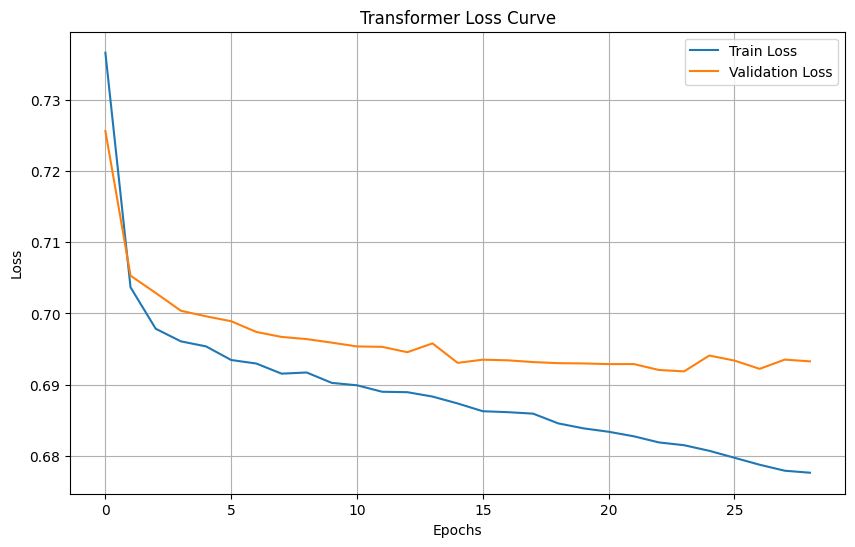


evaluating the model on the test set...

Transformer's performance:
Accuracy: 0.523967
Precision: 0.477435
Recall: 0.747212
F1 Score: 0.582609


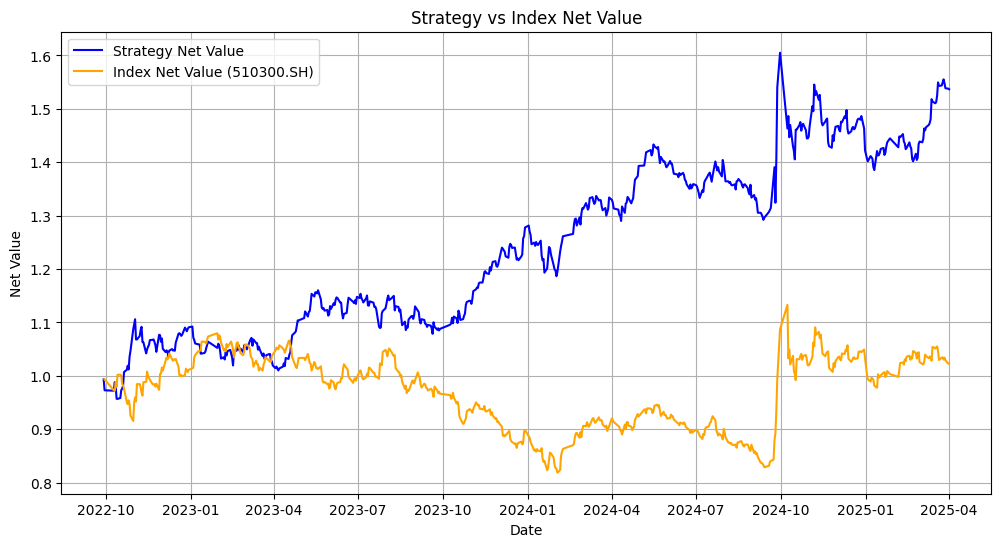

Annualized Return: 0.19631589404631988
Daily Win Rate: 0.5165562913907285



In [15]:
transformer_results = main_transformer()
transformer_preds = transformer_results['transformer_preds']
transformer_preds = transformer_results['transformer_preds'].flatten()
train_size = int(len(df) * (1 - TEST_SIZE))
transformer_pred_series = pd.Series(transformer_preds, index=range(train_size+WINDOW_SIZE+1, train_size+WINDOW_SIZE+1 + len(transformer_preds)))
df['transformer_preds'] = transformer_pred_series
df.to_excel('transformer_output.xlsx', index=False)
transformer_backtest = df.loc[train_size+WINDOW_SIZE+1:, ['Date', 'close', 'transformer_preds']]
transformer_backtest.rename(columns={'transformer_preds': 'preds', 'Date':'date'}, inplace=True)
transformer_backtest.reset_index(drop=True, inplace=True)
transformer_backtest.to_excel('transformer_output.xlsx', index=False) 
backtest_strategy(transformer_backtest)
print()